# Comparison of GP Classification Methods with Logistic Regression

Here, we will compare the performance, both in terms of accuracy and computational efficiency, of different GP classification methods and logistic regression. The simulation we will be look at vary in terms of: 

* Number of inducing points (where relevant).
* Number of training points.
* "Smoothness" of function being simulated.
* Dimension of data

For our analysis, we will consider both the classification rate on the test set as well as the mean computation time (computed via the magic %%timeit function). This is presented via time-performance graph.

We may also look at the negative log probability for performance in future runs. But for this notebook, it is omitted.

In [3]:
%pylab inline
import time
import GPy
import numpy as np
import matplotlib;matplotlib.rcParams['figure.figsize']=(10,6)
from matplotlib import pyplot as plt
from scipy import optimize

Populating the interactive namespace from numpy and matplotlib


# Simulation 1

In this simulation, we are going to consider a simple, 1D nonlinear latent function (the cosine function). In subsequent functions, we will consider higher-dimensional functions with more complex nonlinearity as well as a higher number of input points.

## Setting Up Simulation Data

Here, we will set up our simulated data. 

Firstly we set up our data, $X$. This consists of 100 data points in the range \[0,12).  <br>
Secondly, we apply a cosine transformation on $X$.

Next, we transform the function values f to probabilities, via the sigmoid function. This is stored in $p$.
In order to set up the simulation data, we then random assign classes (0 or 1) to our data. This is done by comparing the probabilities to an array of randomly generated probabilities.

In order to allow for the sparse methods, we also draw inducing points similar to the construction of $X$. <br>
Here, 10 inducing points are used, and are stored in $Z$.

In [12]:
np.random.seed(101)             #to make it reproducible

X = np.random.rand(100,1)*12    #draws from uniform distribution on [0,1) scaled by 12; data
f = np.cos(X/3)*3.8             #Appling f to X
p = np.exp(f)/(1+np.exp(f))      #Applying sigmoid function to f to return probabilities
Y = np.where(p>np.random.rand(*p.shape), 1,0)    #assign random classes
M=10
Z=np.random.rand(M,1)*12        #10 draws fron uniform distribution scaled by 12, inducing points

In [73]:
print(f"X: {X.shape}, f:{f.shape}, p: {p.shape}\nY:{Y.shape}, Z:{Z.shape}")

X: (100, 1), f:(100, 1), p: (100, 1)
Y:(100, 1), Z:(10, 1)


In [13]:
#Ordering variables

order = np.argsort(X[:,0])
X_ordered = X[order]
f_ordered = f[order]
p_ordered = p[order]

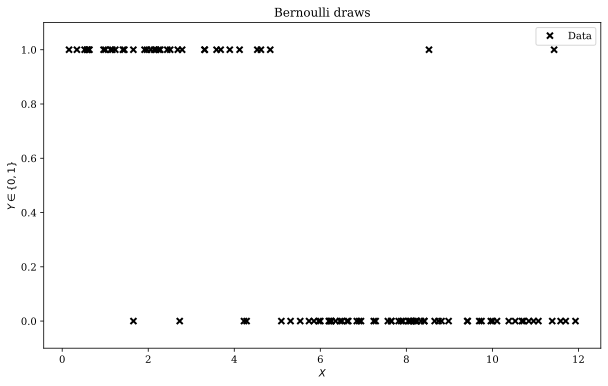

In [75]:
#Plot of data

plt.plot(X, Y, 'kx', mew=2)
plt.ylim(-0.1, 1.1)
plt.title('Bernoulli draws')
plt.xlabel('$X$')
plt.ylabel('$Y \in \{0,1\}$')
plt.legend( ["Data"], loc="best")

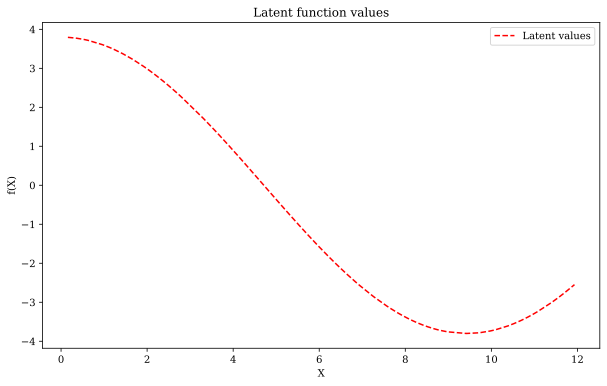

In [76]:
#Plotting latent function values

plt.plot(X_ordered, f_ordered, color="red", ls="--")
plt.title('Latent function values')
plt.xlabel('X')
plt.ylabel('f(X)')
plt.legend( ['Latent values'], loc="best")
#plt.plot(X, p, 'r.')

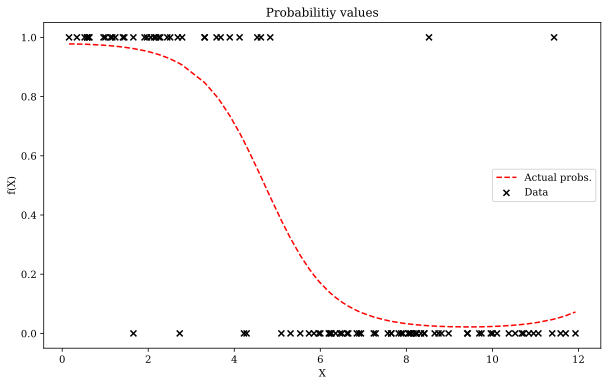

In [77]:
#Plotting actual probabilities

plt.plot(X_ordered, p_ordered, color="red", ls="--")
plt.scatter(X,Y, color="black", marker="x")
plt.title('Probabilitiy values')
plt.xlabel('X')
plt.ylabel('f(X)')
plt.legend( ['Actual probs.', "Data"], loc="best")
#plt.plot(X, p, 'r.')

## GP Variational Classification

In [78]:
#Stochastic Variational GP model, with sparse approximations 


m = GPy.core.SVGP(X, Y, kernel=GPy.kern.RBF(1)+GPy.kern.White(1), likelihood=GPy.likelihoods.Bernoulli(), Z=Z)

Text(0.5, 1.0, 'Prediction of latent probabilities - sparse model, optimized')

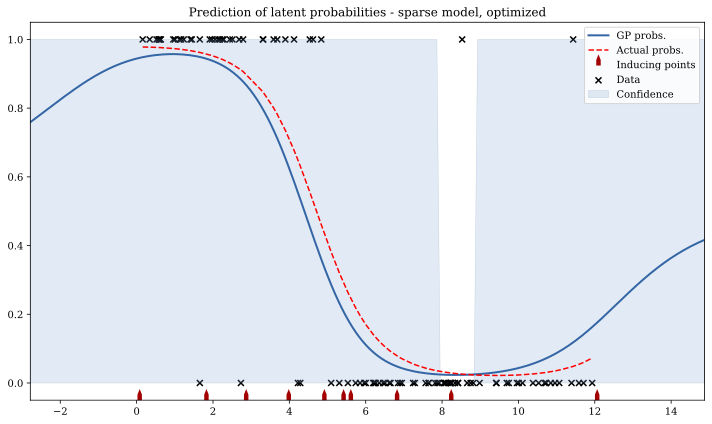

In [79]:
#Optimizing model and plotting model probabilities

t0 = time.time()
m.optimize('bfgs')
t1 = time.time()

m.plot()   #model plot of probabilities
plt.plot(X_ordered, p_ordered, color="red", ls="--")   #actual plot of probabilities
plt.legend( ['GP probs.', 'Actual probs.', "Inducing points", "Data", "Confidence"])
plt.title("Prediction of latent probabilities - sparse model, optimized")
#plt.plot(X, p, 'r.')

In [80]:
#Time taken

print(f'Time taken for sparse variational model: {t1-t0}')

Time taken for sparse variational model: 4.345360040664673


In [81]:
#Model output 

dir(m) #model attributes
m

SVGP.,value,constraints,priors
inducing inputs,"(10, 1)",,
sum.rbf.variance,2.9999787868835197,+ve,
sum.rbf.lengthscale,3.7240554409068642,+ve,
sum.white.variance,1.6249731866773232e-05,+ve,
q_u_chol,"(55, 1)",,
q_u_mean,"(10, 1)",,


In [82]:
#Full model, without sparse approximations

m_full = GPy.models.GPVariationalGaussianApproximation(X, Y, kernel=GPy.kern.RBF(1)+GPy.kern.White(1), likelihood=GPy.likelihoods.Bernoulli())

Text(0.5, 1.0, 'Prediction of latent probabilities - full model, optimized')

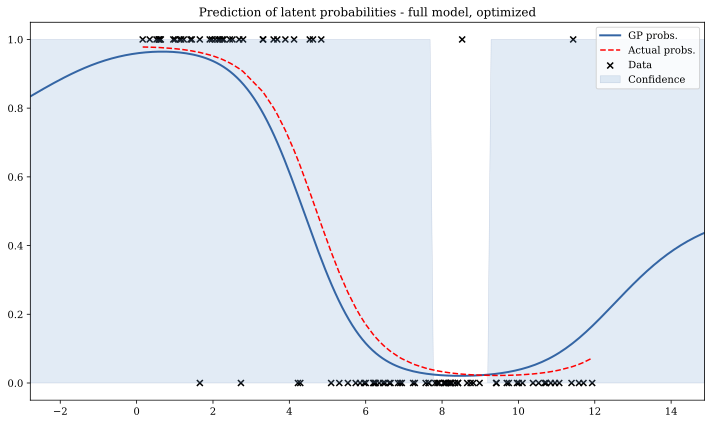

In [83]:
#Optimizing model and plotting model probabilities

t0 = time.time()
m_full.optimize()
t1 = time.time()

m_full.plot()   #full model plot of probabilities 
plt.plot(X_ordered, p_ordered, color="red", ls="--")  #actual plot of probabilities
plt.legend( ['GP probs.', 'Actual probs.', "Data", "Confidence"])
plt.title("Prediction of latent probabilities - full model, optimized")

#plt.plot(X, p, 'r.')

In [84]:
#Time taken

print(f'Time taken for full variational model: {t1-t0}')

Time taken for full variational model: 0.7755692005157471


In [85]:
#Model output

dir(m_full)  #model attributes
m_full

VarGP.,value,constraints,priors
sum.rbf.variance,4.192081087042261,+ve,
sum.rbf.lengthscale,4.171985812817122,+ve,
sum.white.variance,0.00020264866141370632,+ve,
alpha,"(100, 1)",,
beta,"(100,)",,


## GP Laplacian Classification

In [2]:
#PLotting specifications

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#import matplotlib;matplotlib.rcParams['text.usetex'] = True
import matplotlib;matplotlib.rcParams['font.size'] = 16
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'

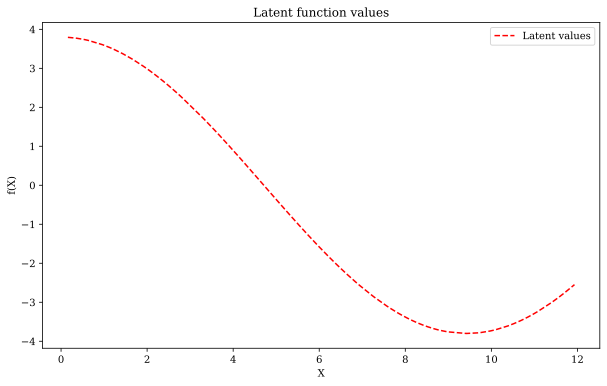

In [86]:
#Plotting latent function values again

plt.plot(X_ordered, f_ordered, color="red", ls="--")
plt.title('Latent function values')
plt.xlabel('X')
plt.ylabel('f(X)')
plt.legend( ['Latent values'], loc="best")
#plt.plot(X, p, 'r.')

In [14]:
#Obtaining probabilities for Laplacian method - uses probit link instead of logit

lik = GPy.likelihoods.Bernoulli()    #Bernoulli likelihood
p = lik.gp_link.transf(f)            #Link function giving probabilities associated with f - applies probit transformation
p_ordered = p[order]
p.shape

(100, 1)

Text(0, 0.5, '$\\sigma(f(x))$')

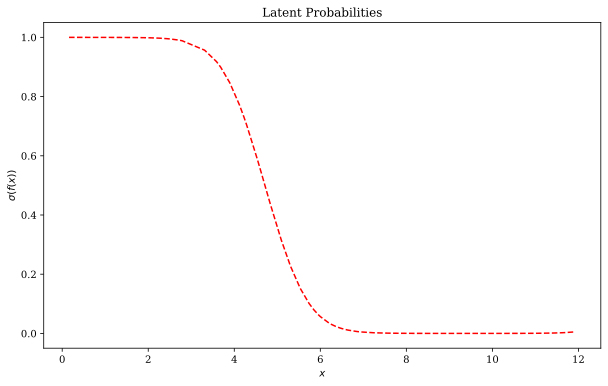

In [15]:
#Plot of latent probabilities obtained from f

plt.plot(X_ordered, p_ordered, color="red", ls="--")
plt.title('Latent Probabilities')
plt.xlabel('$x$')
plt.ylabel('$\sigma(f(x))$')

In [90]:
#Creating Laplacian inference model

kl = GPy.kern.RBF(1, variance=1., lengthscale=1)        #Kernel with specific legnthscale and variance, both set to units
laplace_inf = GPy.inference.latent_function_inference.Laplace()
m_laplace = GPy.core.GP(X=X,
                Y=Y, 
                kernel=kl, 
                inference_method=laplace_inf,
                likelihood=lik)

In [91]:
#Output of unoptimized model

print(m_laplace)


Name : gp
Objective : 33.04246166048295
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp.              |  value  |  constraints  |  priors
  rbf.variance     |    1.0  |      +ve      |        
  rbf.lengthscale  |    1.0  |      +ve      |        


Text(0.5, 1.0, 'Prediction of latent values - unoptimized')

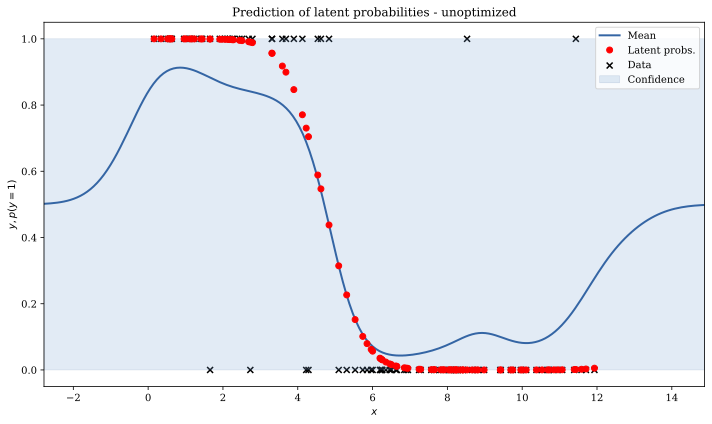

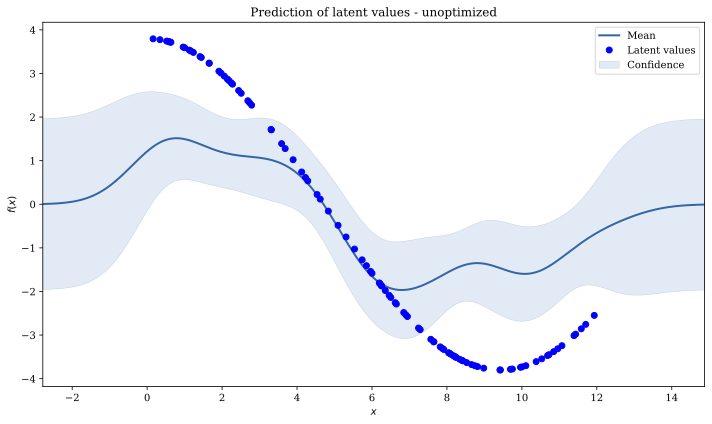

In [92]:
#Plot Laplacian inference model, unoptimized

#Plot of latent probabilities, with predictions of mean and confidence intervals

m_laplace.plot()
plt.plot(X_ordered, p_ordered, color="red", ls="--")
plt.ylabel('$y, p(y=1)$')
plt.xlabel('$x$')
plt.legend( ["Mean", "Latent probs.", "Data", "Confidence"], loc="best")
plt.title("Prediction of latent probabilities - unoptimized")

m_laplace.plot_f()
plt.plot(X_ordered, f_ordered, color="red", ls="--")
plt.ylabel('$f(x)$')
plt.xlabel('$x$')
plt.legend( ["Mean", "Latent values", "Confidence"], loc="best")
plt.title("Prediction of latent values - unoptimized")

In [93]:
#Optimizing 

t0= time.time()
m_laplace.optimize('bfgs', max_iters=100)
t1 = time.time()
print(m_laplace)


Name : gp
Objective : 29.601208017351286
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp.              |               value  |  constraints  |  priors
  rbf.variance     |  2.7412975551338232  |      +ve      |        
  rbf.lengthscale  |  3.6137778096123934  |      +ve      |        


In [94]:
#Time taken

print(f'Time taken for Laplacian model: {t1-t0}')

Time taken for Laplacian model: 0.46350646018981934


Text(0.5, 1.0, 'Prediction of latent values - optimized')

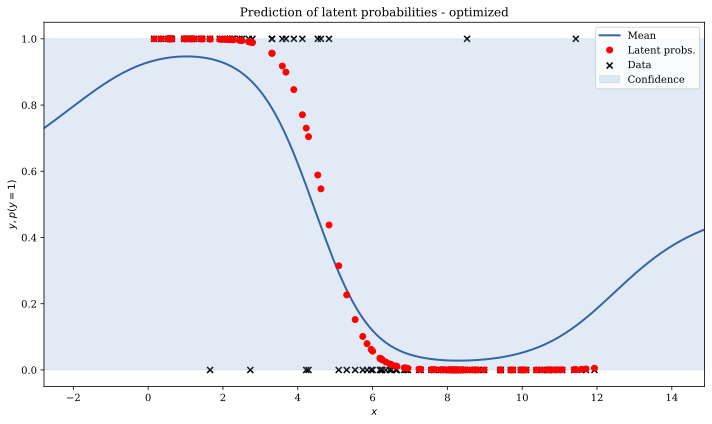

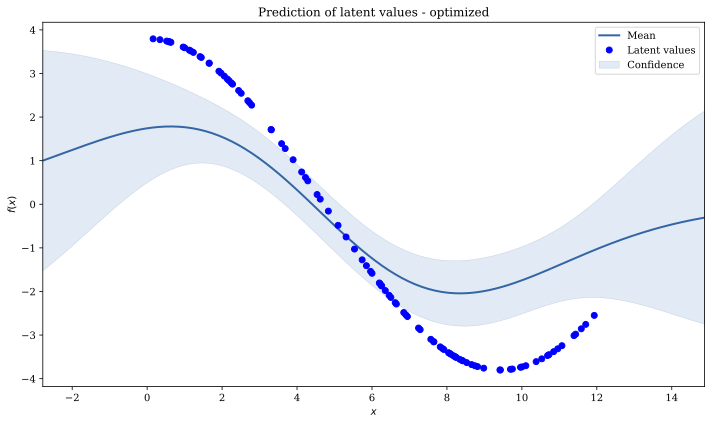

In [95]:
#Plot Laplacian inference model, optimized

#Plot of latent probabilities, with predictions of mean and confidence intervals


m_laplace.plot()
plt.plot(X_ordered, p_ordered, color="red", ls="--")
plt.ylabel('$y, p(y=1)$')
plt.xlabel('$x$')
plt.legend( ["Mean", "Latent probs.", "Data", "Confidence"], loc="best")
plt.title("Prediction of latent probabilities - optimized")

m_laplace.plot_f()
plt.plot(X_ordered, f_ordered, color="red", ls="--")
plt.ylabel('$f(x)$')
plt.xlabel('$x$')
plt.legend( ["Mean", "Latent values", "Confidence"], loc="best")
plt.title("Prediction of latent values - optimized")

## Logistic Regression for Classification

In [2]:
#Importing necessary modules

import pandas as pd
from statsmodels.tools import add_constant
import statsmodels.api as sm
from scipy.special import expit, logit

In [97]:
#Fitting logistic regression model with logit link, including intercept term

X_design = add_constant(X)
model = sm.Logit(Y, X_design).fit()

Optimization terminated successfully.
         Current function value: 0.276896
         Iterations 7


In [98]:
#Model summary

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                            1
Date:                Fri, 04 Dec 2020   Pseudo R-squ.:                  0.5798
Time:                        10:09:44   Log-Likelihood:                -27.690
converged:                       True   LL-Null:                       -65.896
Covariance Type:            nonrobust   LLR p-value:                 2.303e-18
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0475      0.868      4.664      0.000       2.347       5.748
x1            -0.8986      0.168     -5.349      0.000      -1.228      -0.569
==============================================================================
"""

In [99]:
#Making predictions of latent probabilities

predictions = model.predict(X_design).reshape(100,1)
predictions.shape

(100, 1)

In [100]:
#Finding 95% confidence intervals for predicted probabilities

se= np.sqrt(np.array([xx@model.cov_params()@xx for xx in X_design]))   #standards errors of predictions
se = se.reshape(100,1)                                                 #reshaping se
conf_lower_prob = expit(logit(predictions) - 1.96*se)
conf_upper_prob = expit(logit(predictions) + 1.96*se)

Text(0.5, 1.0, 'Prediction of latent probabilities - optimized')

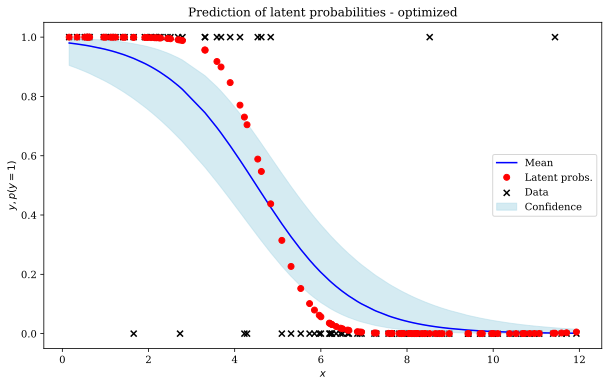

In [101]:
#Plotting mean of predictions with 95% confidence interval

#Ordering for plotting

ordered_pred = predictions[order]                      #ordering probability predictions
ordered_conf_lower_prob = conf_lower_prob[order]               #Order confidence intervals for plotting
ordered_conf_upper_prob = conf_upper_prob[order]     

plt.plot(X_ordered, ordered_pred, color="blue")
plt.scatter(X, Y, marker="x", color="black")
plt.plot(X_ordered, p_ordered, color="red", ls="--")
plt.fill_between(X_ordered.reshape(100), ordered_pred.reshape(100), 
                 ordered_conf_upper_prob.reshape(100), color='lightblue', alpha=.5)
plt.fill_between(X_ordered.reshape(100), ordered_conf_lower_prob.reshape(100), 
                 ordered_pred.reshape(100), color='lightblue', alpha=.5)
plt.ylabel('$y, p(y=1)$')
plt.xlabel('$x$')
plt.legend( ["Mean", "Latent probs.", "Data", "Confidence"], loc="best")
plt.title("Prediction of latent probabilities - optimized")


#Upper confidence bound and lower confidence bound

#plt.plot(X_ordered, ordered_conf_lower_prob, color="violet")
#plt.plot(X_ordered, ordered_conf_upper_prob, color="violet")

Text(0.5, 1.0, 'Prediction of latent values - optimized')

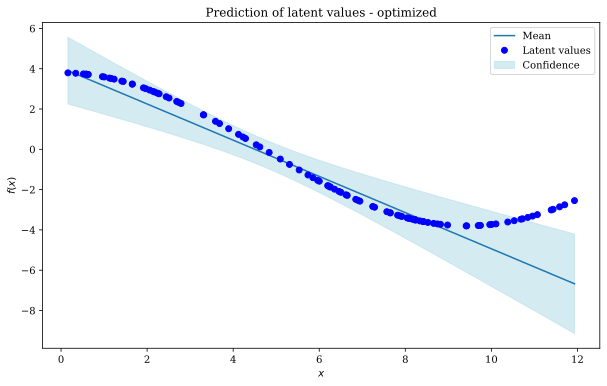

In [102]:
#Prediction of latent values

ordered_values_pred = logit(ordered_pred)   #ordered value predictions obtained by  applying logit to probability predictions

plt.plot(X_ordered, ordered_values_pred)
plt.plot(X_ordered, f_ordered, color="red", ls="--")
plt.fill_between(X_ordered.reshape(100), ordered_values_pred.reshape(100), 
                 logit(ordered_conf_upper_prob).reshape(100), color='lightblue', alpha=.5)
plt.fill_between(X_ordered.reshape(100), logit(ordered_conf_lower_prob).reshape(100), 
                 ordered_values_pred.reshape(100), color='lightblue', alpha=.5)
plt.ylabel('$f(x)$')
plt.xlabel('$x$')
plt.legend( ["Mean", "Latent values", "Confidence"], loc="best")
plt.title("Prediction of latent values - optimized")

## Comparing Classification Methods

Here we will compare the classification methods based on their fit to the training data. For the future we may consider subsetting our data into a train-validation-test split.

In [103]:
#Prediction from sparse variational model
#Classification bsaed on threshold of 0.5

predict_sparse_var = m.predict(X)[0]
classification_sparse_var = np.where(predict_sparse_var >= 0.5, 1, 0)
CRR_sparse_var = np.where(classification_sparse_var == Y)[0].size/Y.size    #corect classification rate

In [104]:
#Prediction from full variational model
#Classification bsaed on threshold of 0.5

predict_full_var = m_full.predict(X)[0]
classification_full_var = np.where(predict_full_var >= 0.5, 1, 0)
CRR_full_var = np.where(classification_full_var == Y)[0].size/Y.size    #corect classification rate

In [105]:
CRR_full_var, CRR_sparse_var

(0.91, 0.91)

In [106]:
#Prediction from laplacian model
#Classification bsaed on threshold of 0.5

predict_laplace = m_laplace.predict(X)[0]
classification_laplace = np.where(predict_laplace >= 0.5, 1, 0)
CRR_laplace = np.where(classification_laplace == Y)[0].size/Y.size    #corect classification rate

In [107]:
CRR_laplace

0.91

In [108]:
#Prediction from logistic regression model
#Classification bsaed on threshold of 0.5

classification_logistic = np.where(predictions >= 0.5, 1, 0)
CRR_logistic = np.where(classification_logistic == Y)[0].size/Y.size    #corect classification rate

In [109]:
CRR_logistic

0.91

## Summary: 

Here, we see that all the models produced the same classification rate. However, by inspection of the latent probability and function value plots, it is clear the there are differences between the models. In particular, we see that the sparse an full variational method provide the best fit to the latent probabilitiies and function values. Following from this, the Laplacian models provides the second best fit and the logistic regression models the third best fit.

For further comparison, it may be useful to plot ROC curves and calculate AUCs for the respective models. This can either be directly coded or done via open-source packages such as scikit-learn.


<ins>**Note**</ins>: The sparse variational model performed around at the same level as the full varational model, with a reduction in computation time.


# Simulation 2

In this part, we will look at making the nonlinearity of the latent function more complex. For simplicity and time-reasons, we will use the data with just 100 input points. The idea here is to demonstrate the flexibility of GP models, while showing the lack of flexibility of logistic regression. Of course we will also demonstrate the comparartive performance of the two different GP models.

More specifically, we insert a scaling term into the argument of the cosine, and keep everything else the same as simulation 1. Our latent function in this case is a periodic function. In subsequent sections we will consider non-periodic functions that are more nonlinearly complex than previous functions.

## Setting Up Simulation Data

Here, we will set up our simulated data. 

The data is set up in the exact same way as in simulation 1, but with the period of the trigonometric latent function decreased.

In [8]:
np.random.seed(101)             #to make it reproducible

X = np.random.rand(100,1)*12    #draws from uniform distribution on [0,1) scaled by 12; data
f = np.cos(5*X/3)*3.8             #Appling f to X
p =np.exp(f)/(1+np.exp(f))      #Applying sigmoid function to f to return probabilities
Y = np.where(p>np.random.rand(*p.shape), 1,0)    #assign random classes
M=10
Z=np.random.rand(M,1)*12        #10 draws fron uniform distribution scaled by 12, inducing points

In [112]:
print(f"X: {X.shape}, f:{f.shape}, p: {p.shape}\nY:{Y.shape}, Z:{Z.shape}")

X: (100, 1), f:(100, 1), p: (100, 1)
Y:(100, 1), Z:(10, 1)


In [9]:
#Ordering variables

order = np.argsort(X[:,0])
X_ordered = X[order]
f_ordered = f[order]
p_ordered = p[order]

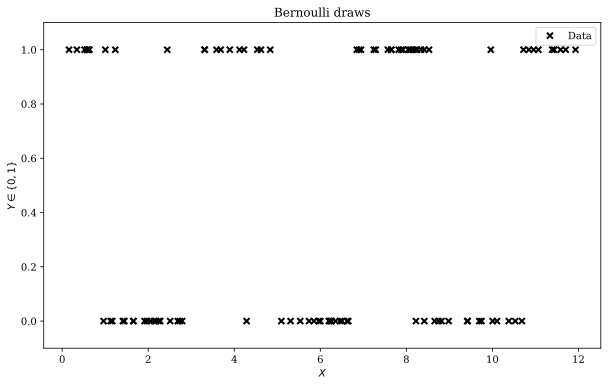

In [114]:
#Plot of data

plt.plot(X, Y, 'kx', mew=2)
plt.ylim(-0.1, 1.1)
plt.title('Bernoulli draws')
plt.xlabel('$X$')
plt.ylabel('$Y \in \{0,1\}$')
plt.legend( ["Data"], loc="best")

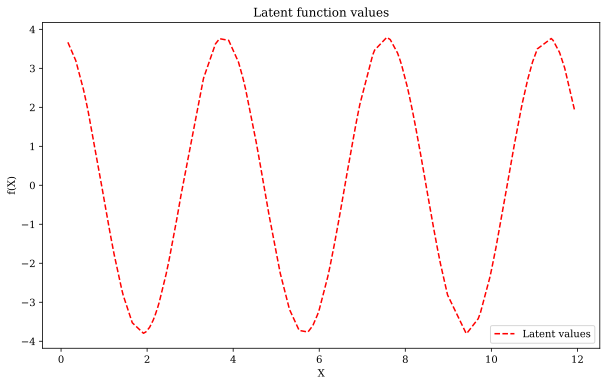

In [115]:
#Plotting latent function values

plt.plot(X_ordered, f_ordered, color="red", ls="--")
plt.title('Latent function values')
plt.xlabel('X')
plt.ylabel('f(X)')
plt.legend( ['Latent values'], loc="best")
#plt.plot(X, p, 'r.')

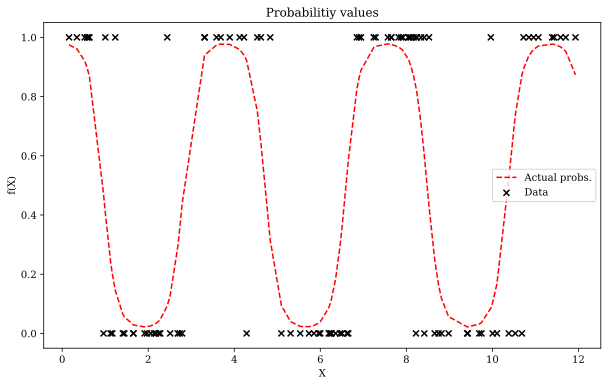

In [116]:
#Plotting actual probabilities

plt.plot(X_ordered, p_ordered, color="red", ls="--")
plt.scatter(X,Y, color="black", marker="x")
plt.title('Probabilitiy values')
plt.xlabel('X')
plt.ylabel('f(X)')
plt.legend( ['Actual probs.', "Data"], loc="best")
#plt.plot(X, p, 'r.')

## GP Variational Classification

In [117]:
#Stochastic Variational GP model, with sparse approximations 


m = GPy.core.SVGP(X, Y, kernel=GPy.kern.RBF(1)+GPy.kern.White(1), likelihood=GPy.likelihoods.Bernoulli(), Z=Z)

Text(0.5, 1.0, 'Prediction of latent probabilities - sparse model, optimized')

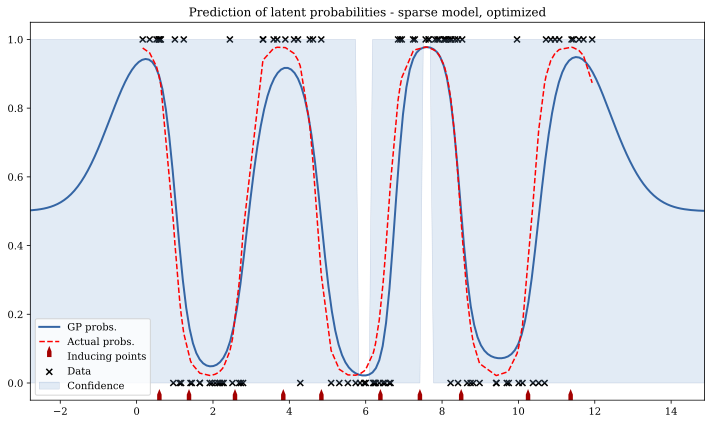

In [118]:
#Optimizing model and plotting model probabilities

t0 = time.time()
m.optimize('bfgs')
t1 = time.time()

m.plot()   #model plot of probabilities
plt.plot(X_ordered, p_ordered, color="red", ls="--")   #actual plot of probabilities
plt.legend( ['GP probs.', 'Actual probs.', "Inducing points", "Data", "Confidence"])
plt.title("Prediction of latent probabilities - sparse model, optimized")
#plt.plot(X, p, 'r.')

In [119]:
#Time taken

print(f'Time taken for sparse variational model: {t1-t0}')

Time taken for sparse variational model: 1.8329801559448242


In [120]:
#Model output 

dir(m) #model attributes
m

SVGP.,value,constraints,priors
inducing inputs,"(10, 1)",,
sum.rbf.variance,4.418240268176476,+ve,
sum.rbf.lengthscale,0.996991582091522,+ve,
sum.white.variance,7.410070716020093e-07,+ve,
q_u_chol,"(55, 1)",,
q_u_mean,"(10, 1)",,


In [121]:
#Full model, without sparse approximations

m_full = GPy.models.GPVariationalGaussianApproximation(X, Y, kernel=GPy.kern.RBF(1)+GPy.kern.White(1), likelihood=GPy.likelihoods.Bernoulli())

Text(0.5, 1.0, 'Prediction of latent probabilities - full model, optimized')

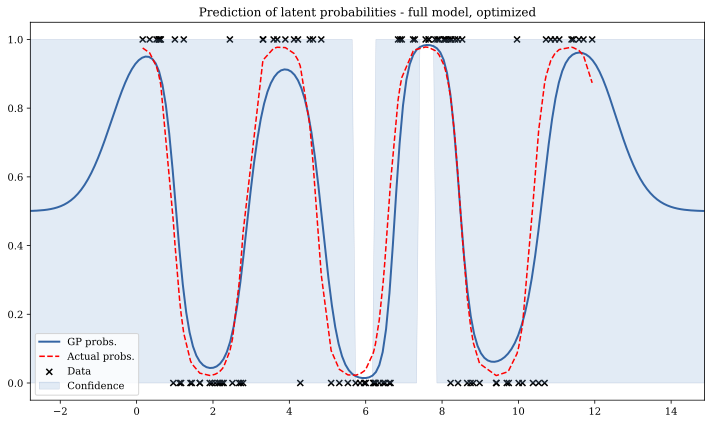

In [122]:
#Optimizing model and plotting model probabilities

t0 = time.time()
m_full.optimize()
t1 = time.time()

m_full.plot()   #full model plot of probabilities 
plt.plot(X_ordered, p_ordered, color="red", ls="--")  #actual plot of probabilities
plt.legend( ['GP probs.', 'Actual probs.', "Data", "Confidence"])
plt.title("Prediction of latent probabilities - full model, optimized")

#plt.plot(X, p, 'r.')

In [123]:
#Time taken

print(f'Time taken for full variational model: {t1-t0}')

Time taken for full variational model: 1.6905243396759033


In [124]:
#Model output

dir(m_full)  #model attributes
m_full

VarGP.,value,constraints,priors
sum.rbf.variance,4.813439659440421,+ve,
sum.rbf.lengthscale,0.9104052268123952,+ve,
sum.white.variance,1.215023660091189e-07,+ve,
alpha,"(100, 1)",,
beta,"(100,)",,


## GP Laplacian Classification

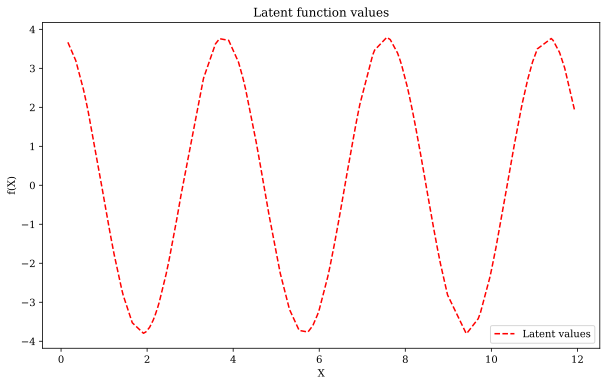

In [125]:
#Plotting latent function values again

plt.plot(X_ordered, f_ordered, color="red", ls="--")
plt.title('Latent function values')
plt.xlabel('X')
plt.ylabel('f(X)')
plt.legend( ['Latent values'], loc="best")
#plt.plot(X, p, 'r.')

In [10]:
#Obtaining probabilities for Laplacian method - uses probit link instead of logit

lik = GPy.likelihoods.Bernoulli()    #Bernoulli likelihood
p_lap = lik.gp_link.transf(f)            #Link function giving probabilities associated with f - applies probit transformation
p_lap_ordered = p_lap[order]
p.shape

(100, 1)

Text(0, 0.5, '$\\sigma(f(x))$')

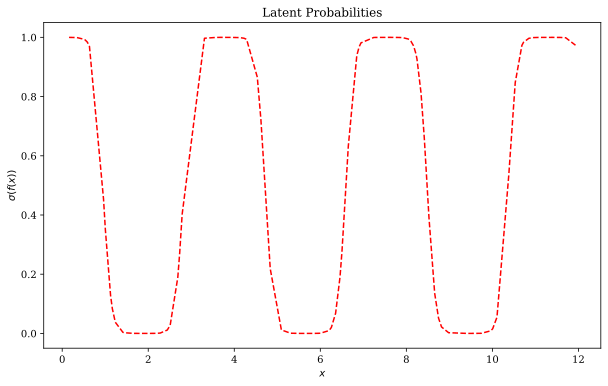

In [11]:
#Plot of latent probabilities obtained from f

plt.plot(X_ordered, p_lap_ordered, color="red", ls="--")
plt.title('Latent Probabilities')
plt.xlabel('$x$')
plt.ylabel('$\sigma(f(x))$')

In [131]:
#Creating Laplacian inference model

t0 = time.time()
kl = GPy.kern.RBF(1, variance=1., lengthscale=1)        #Kernel with specific legnthscale and variance, both set to units
laplace_inf = GPy.inference.latent_function_inference.Laplace()
m_laplace = GPy.core.GP(X=X,
                Y=Y, 
                kernel=kl, 
                inference_method=laplace_inf,
                likelihood=lik)
t1 = time.time()

In [132]:
#Time taken

print(f'Time taken for unoptimized Laplacian model: {t1-t0}')

Time taken for unoptimized Laplacian model: 0.03079390525817871


In [133]:
#Output of unoptimized model

print(m_laplace)


Name : gp
Objective : 49.1037624647741
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp.              |  value  |  constraints  |  priors
  rbf.variance     |    1.0  |      +ve      |        
  rbf.lengthscale  |    1.0  |      +ve      |        


Text(0.5, 1.0, 'Prediction of latent values - unoptimized')

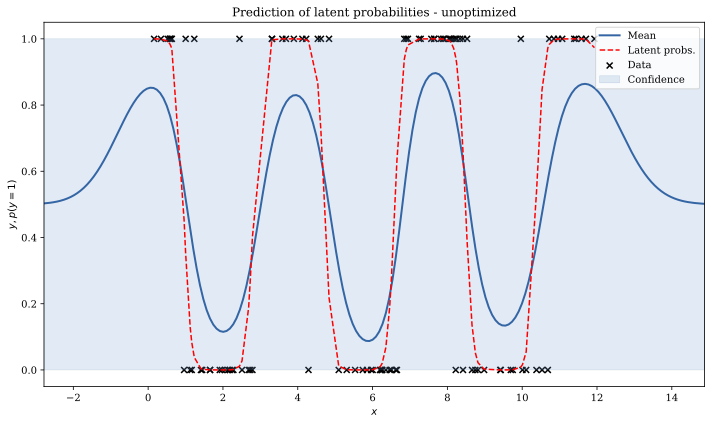

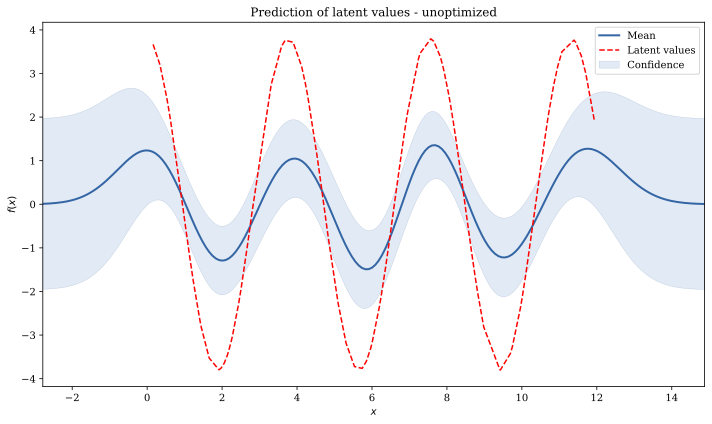

In [136]:
#Plot Laplacian inference model, unoptimized

#Plot of latent probabilities, with predictions of mean and confidence intervals

m_laplace.plot()
plt.plot(X_ordered, p_lap_ordered, color="red", ls="--")
plt.ylabel('$y, p(y=1)$')
plt.xlabel('$x$')
plt.legend( ["Mean", "Latent probs.", "Data", "Confidence"], loc="best")
plt.title("Prediction of latent probabilities - unoptimized")

m_laplace.plot_f()
plt.plot(X_ordered, f_ordered, color="red", ls="--")
plt.ylabel('$f(x)$')
plt.xlabel('$x$')
plt.legend( ["Mean", "Latent values", "Confidence"], loc="best")
plt.title("Prediction of latent values - unoptimized")

In [137]:
#Optimizing 

t0= time.time()
m_laplace.optimize('bfgs', max_iters=100)
t1 = time.time()
print(m_laplace)


Name : gp
Objective : 44.2751455176125
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp.              |               value  |  constraints  |  priors
  rbf.variance     |  4.0956012477577115  |      +ve      |        
  rbf.lengthscale  |  0.7898124121682754  |      +ve      |        


In [138]:
#Time taken

print(f'Time taken for Laplacian model: {t1-t0}')

Time taken for Laplacian model: 0.47130680084228516


Text(0.5, 1.0, 'Prediction of latent values - optimized')

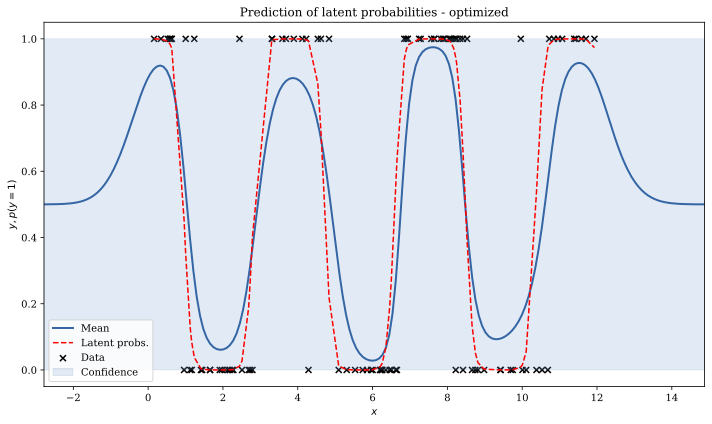

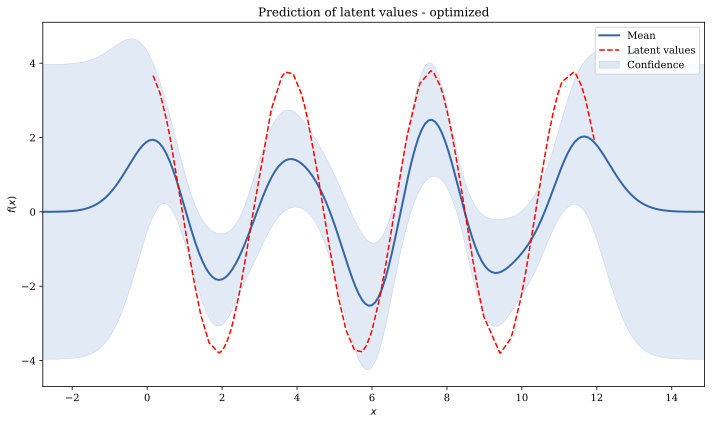

In [139]:
#Plot Laplacian inference model, optimized

#Plot of latent probabilities, with predictions of mean and confidence intervals


m_laplace.plot()
plt.plot(X_ordered, p_lap_ordered, color="red", ls="--")
plt.ylabel('$y, p(y=1)$')
plt.xlabel('$x$')
plt.legend( ["Mean", "Latent probs.", "Data", "Confidence"], loc="best")
plt.title("Prediction of latent probabilities - optimized")

m_laplace.plot_f()
plt.plot(X_ordered, f_ordered, color="red", ls="--")
plt.ylabel('$f(x)$')
plt.xlabel('$x$')
plt.legend( ["Mean", "Latent values", "Confidence"], loc="best")
plt.title("Prediction of latent values - optimized")

## Logistic Regression for Classification

In [140]:
#Fitting logistic regression model with logit link, including intercept term

X_design = add_constant(X)
t0 = time.time()
model = sm.Logit(Y, X_design).fit()
t1 = time.time()

Optimization terminated successfully.
         Current function value: 0.686960
         Iterations 4


In [141]:
#Time taken

print(f'Time taken for logistic regression model: {t1-t0}')

Time taken for logistic regression model: 0.0


In [142]:
#Model summary

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                            1
Date:                Mon, 14 Dec 2020   Pseudo R-squ.:                0.008926
Time:                        10:13:16   Log-Likelihood:                -68.696
converged:                       True   LL-Null:                       -69.315
Covariance Type:            nonrobust   LLR p-value:                    0.2660
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3919      0.408     -0.961      0.336      -1.191       0.407
x1             0.0660      0.060      1.106      0.269      -0.051       0.183
==============================================================================
"""

In [143]:
#Making predictions of latent probabilities

predictions = model.predict(X_design).reshape(100,1)
predictions.shape

(100, 1)

In [144]:
#Finding 95% confidence intervals for predicted probabilities

se= np.sqrt(np.array([xx@model.cov_params()@xx for xx in X_design]))   #standards errors of predictions
se = se.reshape(100,1)                                                 #reshaping se
conf_lower_prob = expit(logit(predictions) - 1.96*se)
conf_upper_prob = expit(logit(predictions) + 1.96*se)

Text(0.5, 1.0, 'Prediction of latent probabilities - optimized')

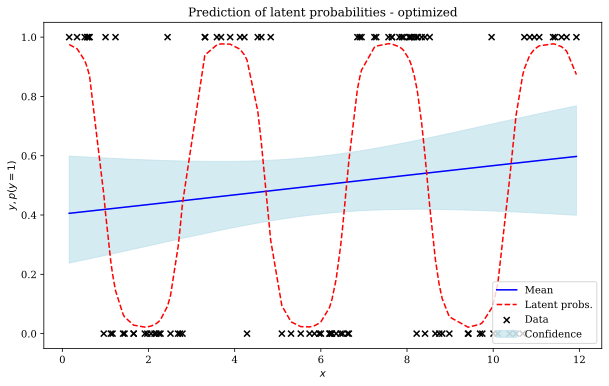

In [145]:
#Plotting mean of predictions with 95% confidence interval

#Ordering for plotting

ordered_pred = predictions[order]                      #ordering probability predictions
ordered_conf_lower_prob = conf_lower_prob[order]               #Order confidence intervals for plotting
ordered_conf_upper_prob = conf_upper_prob[order]     

plt.plot(X_ordered, ordered_pred, color="blue")
plt.scatter(X, Y, marker="x", color="black")
plt.plot(X_ordered, p_ordered, color="red", ls="--")
plt.fill_between(X_ordered.reshape(100), ordered_pred.reshape(100), 
                 ordered_conf_upper_prob.reshape(100), color='lightblue', alpha=.5)
plt.fill_between(X_ordered.reshape(100), ordered_conf_lower_prob.reshape(100), 
                 ordered_pred.reshape(100), color='lightblue', alpha=.5)
plt.ylabel('$y, p(y=1)$')
plt.xlabel('$x$')
plt.legend( ["Mean", "Latent probs.", "Data", "Confidence"], loc="best")
plt.title("Prediction of latent probabilities - optimized")


#Upper confidence bound and lower confidence bound

#plt.plot(X_ordered, ordered_conf_lower_prob, color="violet")
#plt.plot(X_ordered, ordered_conf_upper_prob, color="violet")

Text(0.5, 1.0, 'Prediction of latent values - optimized')

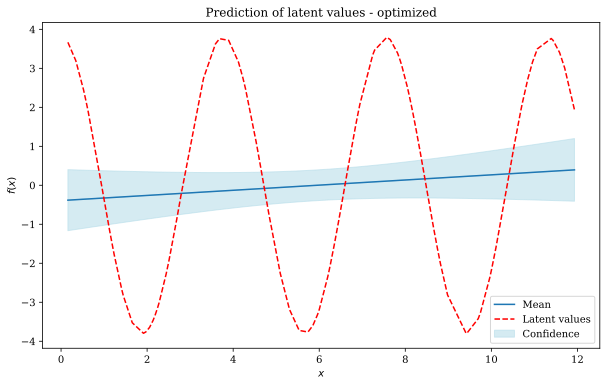

In [146]:
#Prediction of latent values

ordered_values_pred = logit(ordered_pred)   #ordered value predictions obtained by  applying logit to probability predictions

plt.plot(X_ordered, ordered_values_pred)
plt.plot(X_ordered, f_ordered, color="red", ls="--")
plt.fill_between(X_ordered.reshape(100), ordered_values_pred.reshape(100), 
                 logit(ordered_conf_upper_prob).reshape(100), color='lightblue', alpha=.5)
plt.fill_between(X_ordered.reshape(100), logit(ordered_conf_lower_prob).reshape(100), 
                 ordered_values_pred.reshape(100), color='lightblue', alpha=.5)
plt.ylabel('$f(x)$')
plt.xlabel('$x$')
plt.legend( ["Mean", "Latent values", "Confidence"], loc="best")
plt.title("Prediction of latent values - optimized")

## Comparing Classification Methods

Here we will compare the classification methods based on their fit to the training data. For the future we may consider subsetting our data into a train-validation-test split.

In [147]:
#Prediction from sparse variational model
#Classification bsaed on threshold of 0.5

predict_sparse_var = m.predict(X)[0]
classification_sparse_var = np.where(predict_sparse_var >= 0.5, 1, 0)
CRR_sparse_var = np.where(classification_sparse_var == Y)[0].size/Y.size    #corect classification rate

In [148]:
#Prediction from full variational model
#Classification bsaed on threshold of 0.5

predict_full_var = m_full.predict(X)[0]
classification_full_var = np.where(predict_full_var >= 0.5, 1, 0)
CRR_full_var = np.where(classification_full_var == Y)[0].size/Y.size    #corect classification rate

In [149]:
CRR_full_var, CRR_sparse_var

(0.9, 0.9)

In [150]:
#Prediction from laplacian model
#Classification bsaed on threshold of 0.5

predict_laplace = m_laplace.predict(X)[0]
classification_laplace = np.where(predict_laplace >= 0.5, 1, 0)
CRR_laplace = np.where(classification_laplace == Y)[0].size/Y.size    #corect classification rate

In [151]:
CRR_laplace

0.91

In [152]:
#Prediction from logistic regression model
#Classification bsaed on threshold of 0.5

classification_logistic = np.where(predictions >= 0.5, 1, 0)
CRR_logistic = np.where(classification_logistic == Y)[0].size/Y.size    #corect classification rate

In [153]:
CRR_logistic

0.54

### Summary:

Here, logistic regressions performs the worst, whilst the Laplace method performs the best - in terms of CRR on the trianing set. The full and sparse variational models perform the same CRRs.

By inspection, the variational models perform the best approximations for the latent function, followed the the Laplace model then the logistic regression model.

Computation wise, logistic regression was the best, followed by the Laplace model, then by the full variational model then the sparse variational model. This is likely due to the relatively low input size in comparison to the number of parameters being optimized.
